In [1]:
import json
import os
import matplotlib.pyplot as plt

# 1. Explore the dataset 

## 1.1 Load data

In [2]:
data_path="../dutch_data/"
filenames=os.listdir(data_path)

In [3]:
#print filenames
print(filenames)

['dutch1.json', 'dutch2.json', 'dutch3.json', 'dutch4.json']


In [4]:
#load json files
datas=[]
for filename in filenames:
    with open(r'../dutch_data/'+filename, 'r') as f:
        datas+=json.load(f)
        print(len(datas))

5200
9400
12700
18000


In [5]:
#Concatenate all the text for each sentiment
sentiment_map={}
for data in datas:
    if 'sentiment' in data and data['sentiment']!="":
        if data['sentiment'] not in sentiment_map:
            sentiment_map[data['sentiment']]=[data['content']]
        else:
            sentiment_map[data['sentiment']]=sentiment_map[data['sentiment']]+[data['content']]
print("Classes:")       
print(list(sentiment_map.keys()))
print("Num of Positive:")  
print(len(sentiment_map['positive']))
print("Num of Negative:")  
print(len(sentiment_map['negative']))
print("Num of Neutral:")  
print(len(sentiment_map['neutral']))
print("Num of Not Sure:")  
print(len(sentiment_map['not sure']))

Classes:
['neutral', 'positive', 'negative', 'not sure']
Num of Positive:
759
Num of Negative:
179
Num of Neutral:
2228
Num of Not Sure:
148


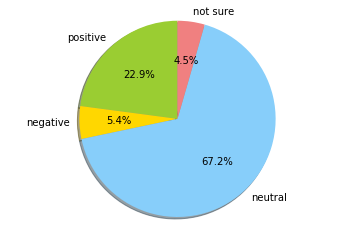

In [6]:
#Pie chart
label=['positive','negative','neutral','not sure']
size=[len(sentiment_map['positive']),len(sentiment_map['negative']),len(sentiment_map['neutral']),len(sentiment_map['not sure'])]
colors=['yellowgreen','gold','lightskyblue','lightcoral']
plt.pie(size,labels=label,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90)
plt.axis('equal')
plt.show()

## 1.2 Word frequency by sentiment

In [7]:
import nltk

import numpy as np
import re

In [8]:
#load stopwords
with open(r'../data/dutch_stopwords.txt', 'r') as f:
    stopwords=f.readlines()
    stopwords=[stopword.strip() for stopword in stopwords]

In [9]:
print(stopwords[0:5])

['aan', 'aangaande', 'aangezien', 'achte', 'achter']


In [10]:
#remove punctuations and stopwords
def text_clean(text):
    # lower
    text=text.lower()
    # remove punctuations
    text=re.sub("[^a-zA-Z]", " ", text)
    # word tokenize
    word_list = nltk.word_tokenize(text)
    # word filter
    word_list=[word for word in word_list if word not in stopwords and len(word)>1]
    return word_list

#word count for each word
def word_count(data_lists):
    # join data
    text=" ".join(data_lists)
    word_list=text_clean(text)
    freq_dist = nltk.FreqDist(word_list)
    return freq_dist

#word frequency count of the words
pos_freq=word_count(sentiment_map['positive'])
neg_freq=word_count(sentiment_map['negative'])
neu_freq=word_count(sentiment_map['neutral'])
ns_freq=word_count(sentiment_map['not sure'])

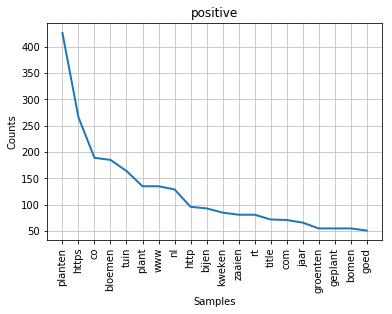

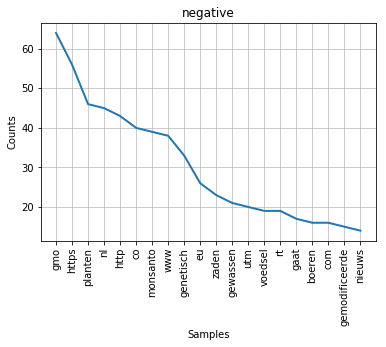

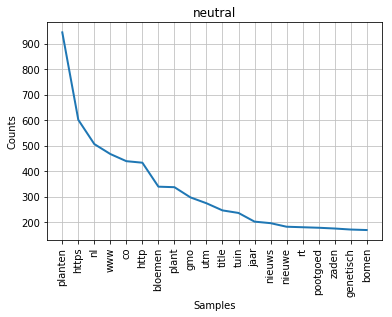

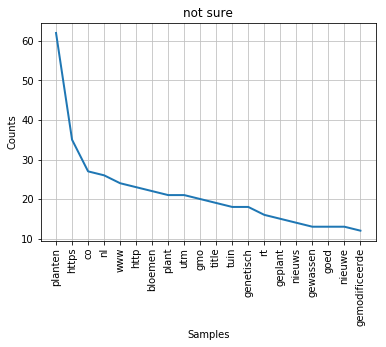

In [11]:
#Top-20 words freq distribution for each of the classes
pos_freq.plot(20,title='positive')
neg_freq.plot(20,title='negative')
neu_freq.plot(20,title='neutral')
ns_freq.plot(20,title='not sure')

## Remove neutral word

From the above pictures we can easily find that positive and negative sentiment have many identical words (such as http, www) and these words are some neutral words. We can remove them to get more emotional words.

In [12]:
from pylab import mpl
import pylab

# convert freq_dist to numpy array
def dist2array(freq_dist):
    freq_list = []
    num_words = len(freq_dist.values())
    for i in range(num_words):
        freq_list.append([list(freq_dist.keys())[i],list(freq_dist.values())[i]])
    freq_list = sorted(freq_list,key=lambda x:x[1],reverse=True)
    freqArr = np.array(freq_list)
    return freqArr

pos_array=dist2array(pos_freq)
neg_array=dist2array(neg_freq)
neu_array=dist2array(neu_freq)
ns_array=dist2array(ns_freq)

In [13]:
print(pos_array[:5])

[['planten' '426']
 ['https' '266']
 ['co' '189']
 ['bloemen' '185']
 ['tuin' '164']]


In [14]:
#Use the intersection of positive and negative sample high frequency words to obtain high frequency neutral words
neutral_word=list(set(pos_array[:100,0]).intersection(set(neg_array[:100,0])))

In [15]:
#some neutral_word examples
print(neutral_word[0:5])

['laten', 'nieuws', 'kweker', 'gmo', 'boeren']


<BarContainer object of 20 artists>

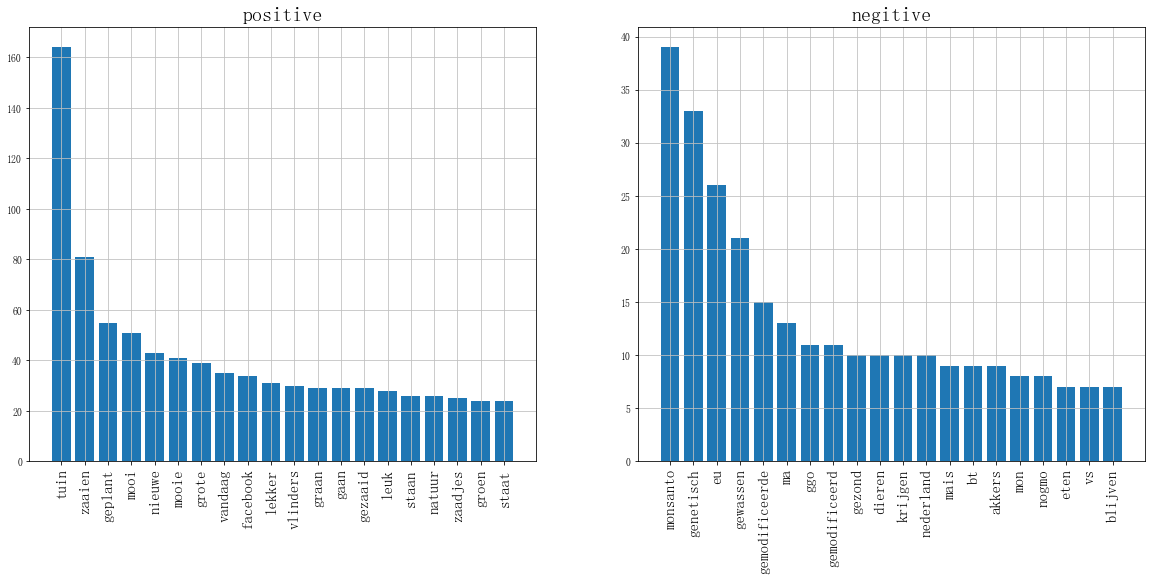

In [16]:
#Re-drawing
#Top-20 words freq distribution for positive and negitive sentiment
num=20
plt.figure(figsize = (20, 8))
mpl.rcParams['font.sans-serif'] = ['FangSong']  
mpl.rcParams['axes.unicode_minus'] = False

plt.subplot(121)
tmp = np.array([x for x in pos_array[:] if x[0] not in neutral_word])[:num]
label=tmp[:,0]
value=[int(x) for x in tmp[:,1]]
pylab.title('positive',fontsize=20)
pylab.xticks(range(len(value)),label, rotation=90,fontsize=15)
pylab.grid(True, color="silver")
plt.bar(range(len(value)), value, tick_label=label)


plt.subplot(122)
tmp = np.array([x for x in neg_array[:] if x[0] not in neutral_word])[:num]
label=tmp[:,0]
value=[int(x) for x in tmp[:,1]]
pylab.title('negitive',fontsize=20)
pylab.xticks(range(len(value)),label, rotation=90,fontsize=15)
pylab.grid(True, color="silver")
plt.bar(range(len(value)), value, tick_label=label)


# my opinion

In my opinion, all words exclude high frequency neutral words and stopwords may contain sentiment information. They play a large part in model decision making.
However, as the number of samples is too small, many features cannot be observed.

# 2.  Feature Extraction 

In [17]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [18]:
texts=sentiment_map['negative']+sentiment_map['positive']+sentiment_map['neutral']

def text_clean2(text):
    # lower
    text=text.lower()
    # remove punctuations
    text=re.sub("[^a-zA-Z]", " ", text)
    # word tokenize
    word_list = nltk.word_tokenize(text)
    # word filter
    word_list=[word for word in word_list if word not in stopwords and len(word)>1]
    return " ".join(word_list)

#clean text and create labels
labels=[]
for i,text in enumerate(texts):
    texts[i]=text_clean2(text)
    if i<len(sentiment_map['negative']):
        labels.append(0)
    elif i<len(sentiment_map['positive'])+len(sentiment_map['negative']):
        labels.append(1)
    elif i<len(texts):
        labels.append(2)
labels=np.array(labels)

In [19]:
vectorizer = CountVectorizer()
freq_table = vectorizer.fit_transform(texts)
freq_table = freq_table.toarray()

In [20]:
print("Total number of examples: "+str(len(freq_table)))
print("Total number of vocabs: "+str(len(freq_table[0])))

Total number of examples: 3166
Total number of vocabs: 15384


In [21]:
print(freq_table)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
print(freq_table.sum(axis=0))

[3 1 2 ... 1 2 1]


## my opinion
The freq_table contains a large number of zero. In other words, it is a sparse matrix. I also use sum function to compute word frequency, that is, the number of times every word appears. The result shows that every word has low frequency. 

# 3.  Model

## 3.1 Data split and weight calculation

In [23]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts,labels,
                                                    train_size=0.9,random_state=30,shuffle=True)

In [24]:
import numpy as np
def weight_fun(x):
    sum_x=sum(x)
    weight=sum_x/x
    weight=weight/min(weight)
    return weight

In [25]:
# weight balance
class_sample_count=np.array([len(np.where(y_train==t)[0]) for t in np.unique(y_train)])
weight=weight_fun(class_sample_count)
w=np.array([weight[t] for t in y_train])

In [26]:
print(class_sample_count)

[ 171  677 2001]


In [27]:
# sample weights
print(w[:10])

[ 1.          1.          1.         11.70175439  2.95568685  1.
  1.          1.          2.95568685  1.        ]


In [28]:
print(y_train[:10])

[2 2 2 0 1 2 2 2 1 2]


# 3.2 TextCNN

1. TextCNN is excellent in extracting text features.
2. I am familiar with CNN and CNN based sentiment is faster and more accurate than RNN based sentiment.

In [52]:
#create datafile
data_path="../data/"
with open(data_path+"textcnn_train.txt","w") as f:
    for i,x in enumerate(X_train):
        s=str(y_train[i])+"\t"+x+"\n"
        s=s*round(float(weight[y_train[i]]))
        f.write(s)
        
with open(data_path+"textcnn_test.txt","w") as f:
    for i,x in enumerate(X_test):
        s=str(y_test[i])+"\t"+x+"\n"
        f.write(s)


### Omit the training process, the specific code is in “model/textcnn/train.py”
Evaluation

In [29]:
#evaluation
import sys
sys.path.append('../model/textcnn/')
import tensorflow as tf
import numpy as np
import os
import time
import datetime
import data_helper
from TextCNN import TextCNN
from tensorflow.contrib import learn
import csv
import sys

# Data Parameters
data_file="../data/textcnn_test.txt"
checkpoint_dir="../model/textcnn/runs/1565274230/checkpoints"
vocab_path="../model/textcnn/runs/1565274230/vocab"
batch_size=64

# CHANGE THIS: Load data. Load your own data here
x_raw, y_test = data_helper.load_data(data_file)
y_test = np.argmax(y_test, axis=1)

# Map data into vocabulary
print(vocab_path)
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)
x_test = np.array(list(vocab_processor.transform(x_raw)))

print("\nEvaluating...\n")

# Evaluation
# ==================================================
checkpoint_file = tf.train.latest_checkpoint(checkpoint_dir)
graph = tf.Graph()
with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=True,
      log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        # Load the saved meta graph and restore variables
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file)

        # Get the placeholders from the graph by name
        input_x = graph.get_operation_by_name("input_x").outputs[0]
        # input_y = graph.get_operation_by_name("input_y").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]

        # Tensors we want to evaluate
        predictions = graph.get_operation_by_name("output/predictions").outputs[0]

        # Generate batches for one epoch
        batches = data_helper.batch_iter(list(x_test), batch_size, 1, shuffle=False)

        # Collect the predictions here
        y_pred = []

        for x_test_batch in batches:
            batch_predictions = sess.run(predictions, {input_x: x_test_batch, dropout_keep_prob: 1.0})
            y_pred = np.concatenate([y_pred, batch_predictions])
            

../model/textcnn/runs/1565274230/vocab
Instructions for updating:
Please use tensorflow/transform or tf.data.

Evaluating...

INFO:tensorflow:Restoring parameters from I:\work\dutch_sentiment\model\textcnn\runs\1565274230\checkpoints\model-4300


In [30]:
# accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test, y_pred)
print("accuracy: "+str(accuracy))

accuracy: 0.668769716088328


In [31]:
# classification report
from sklearn.metrics import classification_report
target_names=['negative','positive','neutral']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.07      0.12      0.09         8
    positive       0.47      0.51      0.49        82
     neutral       0.79      0.74      0.77       227

    accuracy                           0.67       317
   macro avg       0.44      0.46      0.45       317
weighted avg       0.69      0.67      0.68       317



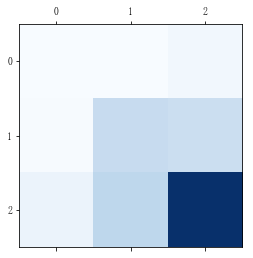

In [32]:
#confusion_matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
plt.matshow(cm,cmap=plt.cm.Blues)

# 4. Conclusion

The accuracy is 0.6687.
I think the sample size is too small. So it couldn't be trained enough. To improve the models performance, it will need bigger dataset and need to change the model to better model.
